# DDPLKO Moduł 11 - praca domowa - Optymalizacja modelu

To jedenasta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [ ] Wykonanie optymalizacji jednego ze swoich modeli: modelu do klasyfikacji rysunków z QuickDraw, modelu wytrenowanego z wykorzystaniem transfer learningu, modelu do klasyfikacji binarnej
- [ ] Możesz wykorzystać pruning lub kwantyzację
- [ ] Porównaj Validation accuracy przed i po optymalizaji
- [ ] Porównaj wielkość zapisanych modeli - przed i po optymalizaji (rozmiar pliku zip z modelem)
- [ ] Udostępnij porównanie validation accuracy dla Twojego modelu przed i po optymalizacji wraz rozmiarami pliku zip na Discordzie `#klasyfikacja-wyniki`

Extra - dodatkowo możesz:
- Jeżeli masz kartę graficzną Nvidia'i, możesz spróbować wykorzystać TensorRT
- Wykonać wykres pruning-rate vs val-acc, by pokazać zależność Validation Accuracy od wartości pruningu (użyj early stoppingu w treningach)

# Dataset preparation

In [1]:
import urllib
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
class_names=['donut', 'alarm clock', 'baseball', 'blueberry', 'cookie', 
             'compass', 'hamburger', 'soccer ball', 'wheel', 'watermelon']

for name in class_names:
    url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy'%name
    file_name = url.split('/')[-1].split('?')[0]

    url = url.replace(' ','%20')
    
    if not os.path.isfile(file_name):
        print(url, '==>', file_name)
        urllib.request.urlretrieve(url, file_name)
        
data = []
for name in class_names:
    file_name = name+'.npy'
    data.append(np.load(file_name, fix_imports=True, allow_pickle=True))
    print('%-15s'%name,type(data[-1]))

donut           <class 'numpy.ndarray'>
alarm clock     <class 'numpy.ndarray'>
baseball        <class 'numpy.ndarray'>
blueberry       <class 'numpy.ndarray'>
cookie          <class 'numpy.ndarray'>
compass         <class 'numpy.ndarray'>
hamburger       <class 'numpy.ndarray'>
soccer ball     <class 'numpy.ndarray'>
wheel           <class 'numpy.ndarray'>
watermelon      <class 'numpy.ndarray'>


In [3]:
# Reduced data
for idx in range(len(data)):
    data[idx] = data[idx][:int(0.25*data[idx].shape[0]), :]
    
data = [_.reshape(-1, 28, 28) for _ in data]

In [4]:
# Reshape data to tf format
X = np.reshape((np.concatenate(data)), (-1, 28, 28, 1))
y = np.concatenate([[idx]*len(category) for idx, category in enumerate(data)])

In [5]:
# Data normalization
X = X / 255

In [6]:
# Train, test, val split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
                        X, y, train_size=0.8, test_size=0.2, stratify=y)

# Model

In [7]:
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
def getModel():
    model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(4, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)),
                tf.keras.layers.AvgPool2D(),
                tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                tf.keras.layers.AvgPool2D(),
                tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
                tf.keras.layers.AvgPool2D(),
                tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(10, activation='softmax')])
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model
model = getModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 4)         40        
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 4)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        1184      
                                                                 
 average_pooling2d_1 (Averag  (None, 7, 7, 32)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 average_pooling2d_2 (Averag  (None, 3, 3, 64)         0

In [9]:
epochs = 30
batch_size = 64

history = model.fit(X_train, y_train,
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_val, y_val),
                   callbacks=[tf.keras.callbacks.EarlyStopping(
                   monitor='val_loss', 
                       patience=5, 
                       verbose=1, 
                       min_delta=0.001,
                       mode='min',
                       restore_best_weights=True,
                   )])

Epoch 1/30
4097/4097 [==============================] - 21s 5ms/step - loss: 0.7187 - accuracy: 0.7703 - val_loss: 0.5393 - val_accuracy: 0.8276
Epoch 2/30
4097/4097 [==============================] - 18s 4ms/step - loss: 0.4916 - accuracy: 0.8438 - val_loss: 0.4622 - val_accuracy: 0.8553
Epoch 3/30
4097/4097 [==============================] - 18s 4ms/step - loss: 0.4293 - accuracy: 0.8627 - val_loss: 0.4465 - val_accuracy: 0.8600
Epoch 4/30
4097/4097 [==============================] - 18s 4ms/step - loss: 0.3908 - accuracy: 0.8750 - val_loss: 0.4102 - val_accuracy: 0.8702
Epoch 5/30
4097/4097 [==============================] - 18s 5ms/step - loss: 0.3620 - accuracy: 0.8842 - val_loss: 0.3929 - val_accuracy: 0.8776
Epoch 6/30
4097/4097 [==============================] - 19s 5ms/step - loss: 0.3392 - accuracy: 0.8909 - val_loss: 0.3756 - val_accuracy: 0.8827
Epoch 7/30
4097/4097 [==============================] - 19s 5ms/step - loss: 0.3197 - accuracy: 0.8965 - val_loss: 0.3812 - val_ac

In [10]:
def plot_history(history, title):
    plt.figure(figsize=(15,7))
    plt.suptitle(title, fontsize=20)
    
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

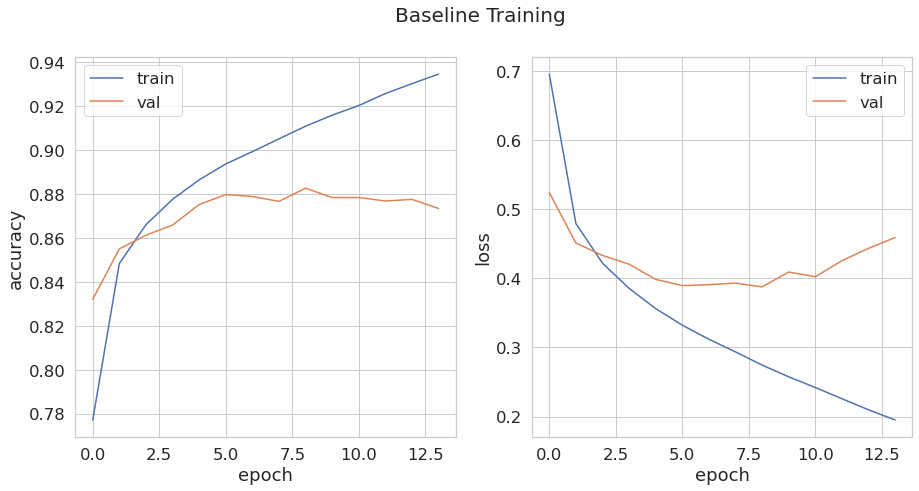

In [11]:
%matplotlib inline
plot_history(history, 'Baseline Training')

In [12]:
tf.keras.models.save_model(model, 'model_baseline.h5', include_optimizer=False)

# Optymalizacja modelu

In [11]:
import tensorflow_model_optimization as tfmot

In [15]:
quantize_model = tfmot.quantization.keras.quantize_model

q_aware_model = quantize_model(model)
q_aware_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28, 1)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 28, 28, 4)        51        
 erV2)                                                           
                                                                 
 quant_average_pooling2d (Qu  (None, 14, 14, 4)        3         
 antizeWrapperV2)                                                
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 14, 14, 32)       1251      
 pperV2)                                                         
                                                                 
 quant_average_pooling2d_1 (  (None, 7, 7, 32)         3

## Fine-tuning with quantization aware training

In [16]:
q_aware_history = q_aware_model.fit(X_train, y_train,
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_val, y_val),
                   callbacks=[tf.keras.callbacks.EarlyStopping(
                   monitor='val_loss', 
                       patience=5, 
                       verbose=1, 
                       min_delta=0.001,
                       mode='min',
                       restore_best_weights=True,
                   )])

Epoch 1/30
4097/4097 [==============================] - 46s 11ms/step - loss: 0.2600 - accuracy: 0.9149 - val_loss: 0.4065 - val_accuracy: 0.8800
Epoch 2/30
4097/4097 [==============================] - 42s 10ms/step - loss: 0.2425 - accuracy: 0.9198 - val_loss: 0.3973 - val_accuracy: 0.8803
Epoch 3/30
4097/4097 [==============================] - 43s 10ms/step - loss: 0.2269 - accuracy: 0.9247 - val_loss: 0.4231 - val_accuracy: 0.8760
Epoch 4/30
4097/4097 [==============================] - 43s 10ms/step - loss: 0.2124 - accuracy: 0.9293 - val_loss: 0.4310 - val_accuracy: 0.8744
Epoch 5/30
4097/4097 [==============================] - 43s 11ms/step - loss: 0.1969 - accuracy: 0.9338 - val_loss: 0.4438 - val_accuracy: 0.8743
Epoch 6/30
4097/4097 [==============================] - 43s 11ms/step - loss: 0.1837 - accuracy: 0.9378 - val_loss: 0.4717 - val_accuracy: 0.8753
Epoch 7/30
4097/4097 [==============================] - 43s 10ms/step - loss: 0.1705 - accuracy: 0.9418 - val_loss: 0.4951 -

In [18]:
tf.keras.models.save_model(q_aware_model, 'q_aware_model.h5', include_optimizer=False)

with tfmot.quantization.keras.quantize_scope():
    q_aware_model = tf.keras.models.load_model('q_aware_model.h5')
    
q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28, 1)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 28, 28, 4)        51        
 erV2)                                                           
                                                                 
 quant_average_pooling2d (Qu  (None, 14, 14, 4)        3         
 antizeWrapperV2)                                                
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 14, 14, 32)       1251      
 pperV2)                                                         
                                                                 
 quant_average_pooling2d_1 (  (None, 7, 7, 32)         3

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

model_quantized = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp5whpv1qh/assets


INFO:tensorflow:Assets written to: /tmp/tmp5whpv1qh/assets


In [21]:
with open('model_quantized.tflite', 'wb') as f:
    f.write(model_quantized)

In [22]:
# Post-training quantization - dynamic range

model_baseline = tf.keras.models.load_model('model_baseline.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model_baseline)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
baseline_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpt8164lcc/assets


INFO:tensorflow:Assets written to: /tmp/tmpt8164lcc/assets


# Porównanie przed i po - Validation Accuracy

In [10]:
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    type_ = interpreter.get_input_details()[0]["dtype"]
    if type_.__name__ == 'uint8':
        X = X_test_255
        in_type = np.uint8
    else:
        X = X_test
        in_type = np.float32

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for test_image in tqdm(X):
    # Pre-processing: add batch dimension and convert to in_type to match with the model's input data format
        test_image = np.expand_dims(test_image, axis=0).astype(in_type)
        interpreter.set_tensor(input_index, test_image)

        # Run inference
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest probability
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    # Compare prediction results with ground truth labels to calculate accuracy
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == y_test).mean()
    
    return accuracy

In [29]:
from tqdm import tqdm
X_test, y_test = X_val[::4], y_val[::4]

interpreter = tf.lite.Interpreter(model_content=baseline_quant)
interpreter.allocate_tensors()

acc_baseline_quant = evaluate_model(interpreter)

100%|██████████| 16388/16388 [01:49<00:00, 149.39it/s]


In [32]:
_, acc_baseline = model.evaluate(X_test, y_test, verbose=0)
q_aware_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
_, acc_q_aware = q_aware_model.evaluate(X_test, y_test, verbose=0)

In [33]:
interpreter = tf.lite.Interpreter(model_content=model_quantized)
interpreter.allocate_tensors()

acc_quantized = evaluate_model(interpreter)

100%|██████████| 16388/16388 [01:48<00:00, 150.38it/s]


In [36]:
print('Validation accuracy:')
print('-'*20)
print('Baseline: ', acc_baseline)
print('Baseline post-training quant: ', acc_baseline_quant)
print('Quantization aware model: ', acc_q_aware)
print('Quantized TFLite model: ', acc_quantized)

Validation accuracy:
--------------------
Baseline:  0.9142665266990662
Baseline post-training quant:  0.9137783744203075
Quantization aware model:  0.922870397567749
Quantized TFLite model:  0.9229314132291921


Text(0.5, 0, '% error')

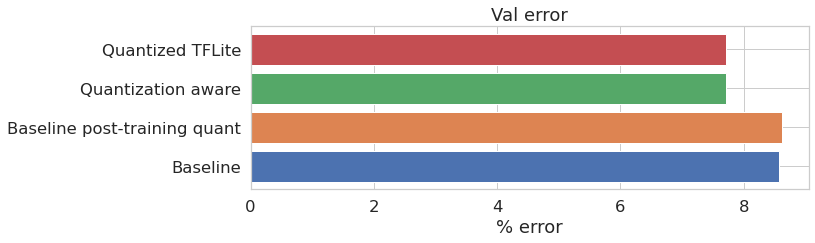

In [38]:
plt.figure(figsize=(10, 3))
plt.title('Val error')

results = [acc_baseline, acc_baseline_quant, acc_q_aware, acc_quantized]
labels = ['Baseline', 'Baseline post-training quant', 'Quantization aware', 'Quantized TFLite']
for label, result in zip(labels, results):
    plt.barh(label, (1-result)*100)
plt.xlabel('% error')

# Porównanie przed i po - Model size

In [40]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
baseline_tflite_model = float_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpkh6c9zxd/assets


INFO:tensorflow:Assets written to: /tmp/tmpkh6c9zxd/assets


In [41]:
with open('model_baseline.tflite', 'wb') as f:
    f.write(baseline_tflite_model)

In [47]:
from prettytable import PrettyTable
import os

summary = PrettyTable()
summary.title = 'Model optimization summary'
summary.field_names = ['Model name', 'Model size [bytes]', 'Val error [%]']


summary.add_row(['Baseline', os.path.getsize('model_baseline.zip'), (1-acc_baseline)*100])
summary.add_row(['Quantized', os.path.getsize('model_quantized.zip'), (1-acc_quantized)*100])


print(summary)

+-----------------------------------------------------+
|              Model optimization summary             |
+------------+--------------------+-------------------+
| Model name | Model size [bytes] |   Val error [%]   |
+------------+--------------------+-------------------+
|  Baseline  |       765584       | 8.573347330093384 |
| Quantized  |       206352       | 7.706858677080786 |
+------------+--------------------+-------------------+


# Summary / extra

## Pruning rate vs val-acc

In [12]:
prune_epochs = 30
num_images = X_train.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * prune_epochs

In [45]:
pruning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude


pruning_params = [{'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0,
                                                                           final_sparsity=sparsity,
                                                                           begin_step=0,
                                                                           end_step=end_step,
                                                                           frequency=100)} 
                  for sparsity in pruning_rates]

callbacks = [tfmot.sparsity.keras.UpdatePruningStep(), # callback obowiązkowy podczas pruningu
             tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_summary'),
            tf.keras.callbacks.EarlyStopping(
                   monitor='val_loss', 
                       patience=5, 
                       verbose=1, 
                       min_delta=0.001,
                       mode='min',
                       restore_best_weights=True,
                   )]
pruning_histories = []
for pruning_schedule in pruning_params:
    
    model_prune = prune_low_magnitude(model, **pruning_schedule)
    model_prune.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
    
    history_prune = model_prune.fit(X_train, y_train,
                                batch_size=batch_size,
                                epochs=prune_epochs,
                                validation_data=(X_val, y_val),
                                callbacks=callbacks)
    pruning_histories.append((pruning_schedule['pruning_schedule'].final_sparsity, history_prune))

In [71]:
def prun_ratio_vs_val_acc(histories):
    plt.figure()
    ys = [max(history[1].history['val_accuracy']) for history in histories]
    xs = [history[0] for history in histories]
    sns.scatterplot(x=xs, y=ys)
    plt.title('Prun ratio vs val accuracy')
    plt.xlabel('Prun ratio')
    plt.ylabel('Val accuracy')    

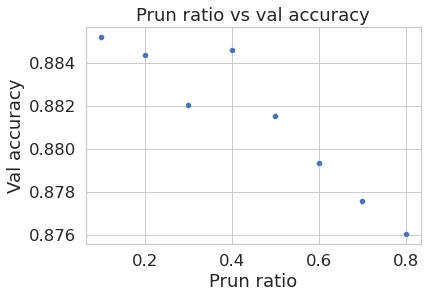

In [72]:
%matplotlib inline
prun_ratio_vs_val_acc(pruning_histories)

# Wyślij rozwiązanie
Możesz skorzystać z jednego z poniższych sposobów:
**mailem na specjalny adres** ze strony pracy domowej w panelu programu prześlij jedno z poniższych:
- notebooka (jeżeli plik ma mniej niż np. 10MB)
- notebooka w zipie
- link do Colaba (udostępniony)
- link do pliku przez GDrive/Dropboxa/WeTransfer/...
- pdfa (poprzez download as pdf)
- jako plik w repozytorium na np. GitHubie, by budować swoje portfolio (wtedy uważaj na wielkość pliku, najlepiej kilka MB, Max 25MB)

Najlepiej, by w notebooku było widać wyniki uruchomienia komórek, chyba, że przez nie plik będzie mieć 100+MB wtedy najlepiej Colab lub jakieś przemyślenie co poszło nie tak (zbyt dużo dużych zdjęć wyświetlonych w komórkach).

## Co otrzymasz?
Informację zwrotną z ewentualnymi sugestiami, komentarzami.